In [2]:
## This is section 2 of a computer vision training module using OpenCV using Python 3
## Written by Max Feldman and Jaebum Park USDA-ARS

## This section will cover measurement of tuber features

## First lets import the libraries
import cv2
import skimage
from skimage import feature
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os.path
import glob
import csv
from datetime import date
from time import sleep
import re
import scipy
import A08241_color_checker_fxns

In [3]:
## Lets quickly generate the data from the last module
## Don't worry about the details here... We covered them in the last tutorial

pwd = os.getcwd()
infile_query = pwd + "/black_background_1/*.jpg"
files = glob.glob(infile_query)
files.sort()
f = files[0]
img = cv2.imread(f)
image_name = f.split("/")[-1]
image_name = image_name.replace(".jpg", "")
imgC = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ix, iy, iz = np.shape(img)
img_crop = imgC[0:1900, 1200:3500]
ix, iy, iz = np.shape(img)
blur = cv2.GaussianBlur(img_crop, (5, 5), 3)
imgHSV = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
imgLAB = cv2.cvtColor(blur, cv2.COLOR_BGR2Lab)
h, s, v = cv2.split(imgHSV)
l, a, b = cv2.split(imgLAB)
r = blur[:, :, 0]
g = blur[:, :, 1]
bl = blur[:, :, 2]
s_ret, s_th = cv2.threshold(s, 75, 255, cv2.THRESH_BINARY)
b_ret_inv, b_th_inv = cv2.threshold(b, 125, 255, cv2.THRESH_BINARY_INV)
chip_ret, chip_th = cv2.threshold(b, 140, 255, cv2.THRESH_BINARY)
mask = cv2.bitwise_and(s_th, b_th_inv)
kernel = np.ones((5, 5), np.uint8)
mask_er = cv2.erode(mask, kernel, iterations=1)
chip_er = cv2.erode(chip_th, kernel, iterations=1)
mask_dil = cv2.dilate(mask_er, kernel, iterations=1)
chip_dil = cv2.dilate(chip_er, kernel, iterations=1)
contours, hierarchy = cv2.findContours(mask_dil, cv2.RETR_TREE, cv2.cv2.CHAIN_APPROX_NONE)
chip_contour, chip_hierarchy = cv2.findContours(chip_dil, cv2.RETR_TREE, cv2.cv2.CHAIN_APPROX_NONE)
chipSorted = sorted(chip_contour, key=lambda x: cv2.contourArea(x), reverse=True)
chip_contour = chipSorted[0]
contours2 = []
it = 0
cXY = []
cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
contours = cntsSorted[0:5]
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 3000:
        contours2.append(cnt)
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        #print(cX)
        #print(cY)
        entry = [it, cX, cY]
        #print(entry)
        cXY.append(entry)
        it += 1
df = pd.DataFrame(cXY, columns=['cnt', 'cmx', 'cmy'])
df = df.sort_values(by='cmx', ascending=False)
right_side = df[:3]
right_side = right_side.sort_values(by='cmy')
left_side = df[3:5]
left_side = left_side.sort_values(by='cmy')
cnt_order = right_side['cnt'].tolist()
cnt_order = cnt_order + left_side['cnt'].tolist()
cnt_order.append(5)
img_draw = img_crop.copy()
contours2.append(chip_contour)

Your current directory is:
/Users/max.feldman/Desktop/python_opencv_tutorial-master
The order of contours is:
[2, 1, 3, 4, 0, 5]
The image name is:
1_1_1_std
Look at the cropped image:


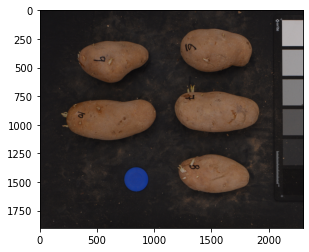

In [4]:
## Lets do a sanity check to make sure the data looks okay
print("Your current directory is:")
print(pwd)
print("The order of contours is:")
print(cnt_order)
print("The image name is:")
print(image_name)
print("Look at the cropped image:")
plt.imshow(img_draw)
plt.show()

In [5]:
## Lets assign some variables that will be used later
output_dir = pwd
output_file_name = output_dir + "output_" + image_name + ".jpg"
img_write = img_draw.copy()
clone, rep, side, light = image_name.split("_")
print("Lets look at some information in the name...\n")
print("Clone is:")
print(clone)
print("Replicate is:")
print(rep)
print("Tuber side is:")
print(side)
print("The background is:")
print(light)
img_out = img_write.copy()

## We will store values from each tuber in tables

## Make column names for color tables (one table for each color channel: R,G,B)
r_names = ["r_" + str(s) for s in list(range(0, 256))]
g_names = ["g_" + str(s) for s in list(range(0, 256))]
b_names = ["b_" + str(s) for s in list(range(0, 256))]

## Make column names for shape table (Shapes will be based upon latent traits)
x_names = ["x_" + str(x) for x in list(range(1, 101))]
y_names = ["y_" + str(y) for y in list(range(1, 101))]
s_names = x_names + y_names

## This is an output file that will be saved
summary_table = pd.DataFrame(columns=['img_name', 'clone', 'rep', 'side', 'light', 'tuber', 'cmx', 'cmy', 'area', 'perimeter', 'length', 'width', 'ratio', 'eccentricity','red_ave', 'green_ave', 'blue_ave'])

## Prepare empty tables for color and shape data
r_table = pd.DataFrame(columns=r_names)
g_table = pd.DataFrame(columns=g_names)
b_table = pd.DataFrame(columns=b_names)
s_table = pd.DataFrame(columns=s_names)

Lets look at some information in the name...

Clone is:
1
Replicate is:
1
Tuber side is:
1
The background is:
std


In [6]:
## Each tuber was weighed and measured using digital calipers at USDA-ARS in Aberdeen
## Lets assign the correct tuber number so it matches with the ground truth data

tuber_no = [1,2,3,4,5,'marker']
counter = 0
print("The replicate number is:")
print(rep)
if (rep == '1'):
    tuber_no = [6,7,8,9,10,'marker']
if (rep == '2'):
    tuber_no = [1,2,3,4,5,'marker']
if (len(cnt_order) == 5):
    tuber_no = tuber_no[:4] + tuber_no[5:]
    cnt_order[-1] = len(cnt_order) - 1

The replicate number is:
1


Here is what the mask of the tuber looks like



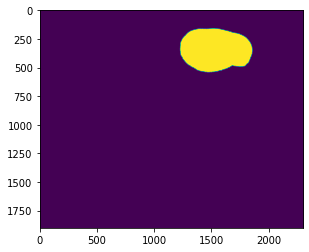

In [7]:
## Here is where we will take the measurments of a single tuber/contour
## This process is largely adopted from the PlantCV fxn named: analyze_object.py
## More information about this can be found here:
## https://plantcv.readthedocs.io/en/stable/analyze_shape/

## The raw code that went into this routine can be found here:
## https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html

## Lets analyze the first contour (contour in top left corner):
val = cnt_order[0]
cnt = contours[val]

## Assign the correct tuber number
tuber = tuber_no[counter]

## Make a copy of the original image to draw on
img_write = img_draw.copy()

## Get moments of the contour
m = cv2.moments(cnt)
## extract area from the moment
area = m['m00']
ix, iy, iz = np.shape(img_write)
size = ix, iy, 3
size1 = ix, iy

## Lets make a black background to write on 
background = np.zeros(size, dtype=np.uint8)
background1 = np.zeros(size1, dtype=np.uint8)
background2 = np.zeros(size1, dtype=np.uint8)
background3 = np.zeros(size1, dtype=np.uint8)

## Lets call this blank image tuber mask (we will draw the current tuber on it)
tuber_mask = background3.copy()

## Draw the contour of this first tuber...
cv2.drawContours(tuber_mask, [cnt], 0, (255, 255, 255), -1)

print("Here is what the mask of the tuber looks like\n")
plt.imshow(tuber_mask)
plt.show()

## Take additinoal measurements
hull = cv2.convexHull(cnt)
m = cv2.moments(cnt)
area = m['m00']
perimeter = cv2.arcLength(cnt, closed=True)

## Get measurement of tuber based upon a bounding rectangle
x, y, width, height = cv2.boundingRect(cnt)
cmx, cmy = (float(m['m10'] / m['m00']), float(m['m01'] / m['m00']))

## Fit an ellipse around the tuber
center, axes, angle = cv2.fitEllipse(cnt)

## What is the length tuber's longest axis?
major_axis = np.argmax(axes)
## how about the minor axis?
minor_axis = 1 - major_axis

## Lets get values of length 
major_axis_length = float(axes[major_axis])

## Lets get values of the width
minor_axis_length = float(axes[minor_axis])

## Lets calculate eccentricity
## https://en.wikipedia.org/wiki/Eccentricity_(mathematics)
eccentricity = float(np.sqrt(1 - (axes[minor_axis] / axes[major_axis]) ** 2))

## For greater description of code below refer to PlantCV fxn named: analyze_object.py 
cv2.circle(background, (int(cmx), int(cmy)), 4, (255, 255, 255), -1)
center_p = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
ret, centerp_binary = cv2.threshold(center_p, 0, 255, cv2.THRESH_BINARY)
centerpoint, cpoint_h = cv2.findContours(centerp_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
dist = []
vhull = np.vstack(hull)
for i, c in enumerate(vhull):
    xy = tuple(c)
    pptest = cv2.pointPolygonTest(centerpoint[0], xy, measureDist=True)
    dist.append(pptest)
abs_dist = np.absolute(dist)
max_i = np.argmax(abs_dist)
caliper_max_x, caliper_max_y = list(tuple(vhull[max_i]))
caliper_mid_x, caliper_mid_y = [int(cmx), int(cmy)]
xdiff = float(caliper_max_x - caliper_mid_x)
ydiff = float(caliper_max_y - caliper_mid_y)
slope = 1
if xdiff != 0:
    slope = (float(ydiff / xdiff))
b_line = caliper_mid_y - (slope * caliper_mid_x)
if slope != 0:
    xintercept = int(-b_line / slope)
    xintercept1 = int((ix - b_line) / slope)
    if 0 <= xintercept <= iy and 0 <= xintercept1 <= iy:
        cv2.line(background1, (xintercept1, ix), (xintercept, 0), (255), 3)
    elif xintercept < 0 or xintercept > iy or xintercept1 < 0 or xintercept1 > iy:
        yintercept = int(b_line)
        yintercept1 = int((slope * iy) + b_line)
        cv2.line(background1, (0, yintercept), (iy, yintercept1), (255), 5)
else:
    cv2.line(background1, (iy, caliper_mid_y), (0, caliper_mid_y), (255), 3)
ret1, line_binary = cv2.threshold(background1, 0, 255, cv2.THRESH_BINARY)
cv2.drawContours(background2, [hull], -1, (255), -1)
ret2, hullp_binary = cv2.threshold(background2, 0, 255, cv2.THRESH_BINARY)
caliper = cv2.multiply(line_binary, hullp_binary)
caliper_y, caliper_x = np.array(caliper.nonzero())
caliper_matrix = np.vstack((caliper_x, caliper_y))
caliper_transpose = np.transpose(caliper_matrix)
caliper_length = len(caliper_transpose)
caliper_transpose1 = np.lexsort((caliper_y, caliper_x))
caliper_transpose2 = [(caliper_x[i], caliper_y[i]) for i in caliper_transpose1]
caliper_transpose = np.array(caliper_transpose2)

## Calculation of aspect ratio
ratio = major_axis_length / minor_axis_length

Here is what the masked potato looks like:



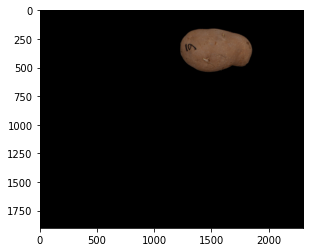

Here is the potato with the length and width drawn on it:



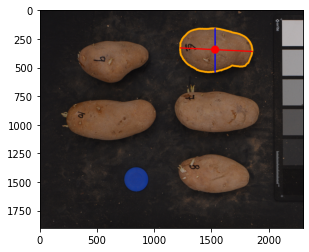

In [8]:
## Lets apply the mask generated in the previous step to isolate the tuber for color measurement
masked_spud = cv2.bitwise_and(img_write, img_write, mask=tuber_mask)

## Lets plot the spud on a black background
print("Here is what the masked potato looks like:\n")
plt.imshow(masked_spud)
plt.show()                



## Lets plot some features on the image
## Draw contour
cv2.drawContours(img_out, cnt, -1, (255, 165, 0), 15)

## Draw width
cv2.line(img_out, (int(cmx), y), (int(cmx), y + height), (0, 0, 255), 10)

## Draw length
cv2.line(img_out, (tuple(caliper_transpose[caliper_length - 1])), (tuple(caliper_transpose[0])), (255, 0, 0), 10)

## Draw centroid
cv2.circle(img_out, (int(cmx), int(cmy)), 10, (255, 0, 0), 50)

## Plot image
print("Here is the potato with the length and width drawn on it:\n")
plt.imshow(img_out)
plt.show()

How many degrees do we need to rotate the contour to make it vertical?

92.12271881103516
Lets look at the rotated image:



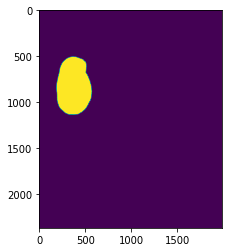

Lets look at the cropped tuber image:



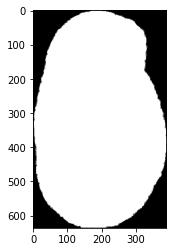

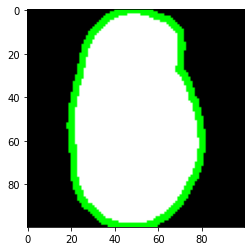

In [9]:
## Lets calculate some latent traits from the tuber contour

## Get rotational degrees to make tuber vertical then rotate
rotation_deg = cv2.fitEllipse(cnt)[2]
print("How many degrees do we need to rotate the contour to make it vertical?\n")
print(rotation_deg)

rotated_img = scipy.ndimage.rotate(tuber_mask, rotation_deg, reshape=True)
print("Lets look at the rotated image:\n")
plt.imshow(rotated_img)
plt.show()


## Get contours of rotated tuber and plot
v_contours, v_hierarchy = cv2.findContours(rotated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
ix, iy = np.shape(rotated_img)
blank_image = np.zeros((ix, iy, 3), np.uint8)
v_tuber_bin = cv2.drawContours(blank_image, [max(v_contours, key=cv2.contourArea)], -1, (255, 255, 255), thickness=cv2.FILLED)

## Fit bounding rectangle to tuber and crop
x, y, w, h = cv2.boundingRect(max(v_contours, key=cv2.contourArea))

## Lets crop the rotated tuber to the minimal size
cropped_tuber = v_tuber_bin[y:y + h, x:x + w]
print("Lets look at the cropped tuber image:\n")
plt.imshow(cropped_tuber)
plt.show()

## Convert to gray scale
cropped_tuber_g = cv2.cvtColor(cropped_tuber, cv2.COLOR_BGR2GRAY)

## Lets make the image a square to maintain aspect ratio
## Add pad of zeros to either size
pad_needed = h - w
pad_needed = abs(pad_needed)
if (pad_needed % 2) == 0:
    pad_val_l = pad_needed / 2
    pad_val_r = pad_val_l
else:
    pad_val_l = int(pad_needed / 2)
    pad_val_r = pad_val_l + 1
cropped_tuber_g = np.pad(cropped_tuber_g, [(0, 0), (int(pad_val_r), int(pad_val_l))], 'constant', constant_values=(0))

## Normalize for axis ratio by resizing to 100 x 100 image
scaled_tuber = cv2.resize(cropped_tuber_g, (100, 100))

## Convert to true binary (0 or 1)
scaled_tuber[scaled_tuber > 0] = 1

## Get row and columnwise sums (aka sweeps)
tuber_x = scaled_tuber.sum(axis=1)
tuber_y = scaled_tuber.sum(axis=0)
s_contours, s_hierarchy = cv2.findContours(scaled_tuber, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
x, y, width, height = cv2.boundingRect([max(s_contours, key=cv2.contourArea)][0])

## Lets get the proportional sweep along each axis
tuber_x = tuber_x/width
tuber_y = tuber_y/height

## Record the sweeps as "shape_values"
shape_values = np.concatenate([tuber_x, tuber_y])
s_row = pd.DataFrame(shape_values.reshape(1,200), columns=s_names)
s_table = s_table.append(s_row, )

ix, iy = np.shape(scaled_tuber)
blank_scaled_image = np.zeros((ix, iy, 3), np.uint8)

## Write out an image of the isolated tuber
cv2.drawContours(blank_scaled_image, [max(s_contours, key=cv2.contourArea)], -1, (255, 255, 255), thickness=cv2.FILLED)
cv2.drawContours(blank_scaled_image, [max(s_contours, key=cv2.contourArea)], -1, (0, 255, 0), thickness=2)
plt.imshow(blank_scaled_image)
plt.show()




Here's the blue channel


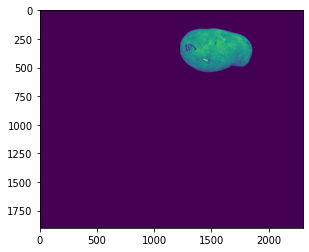

Here's the green channel


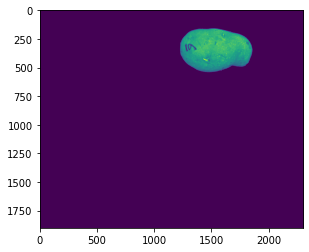

Here's the red channel


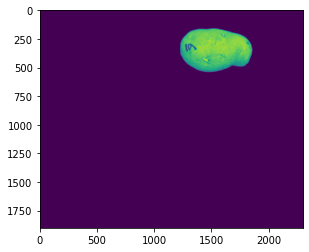

Here is a historgram of color pixels within the tuber



(0.0, 256.0)

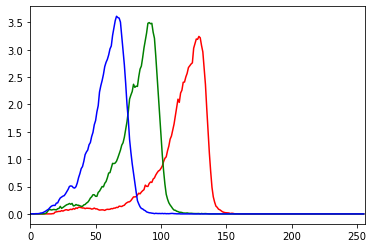

In [12]:
## Lets evaluate some color measurments

## Extract each color channel
r_object, g_object, b_object = cv2.split(masked_spud)

## Lets look at the blue channel
print("Here's the blue channel")
plt.imshow(b_object)
plt.show()

## Lets look at the green channel
print("Here's the green channel")
plt.imshow(g_object)
plt.show()

## Lets look at the red channel
print("Here's the red channel")
plt.imshow(r_object)
plt.show()

## Lets take a look at the color spectrum of the object/spud
## Here we get the number of pixels that fall into each bin with the 3 color spaces
## Note here we are using the mask to define the object of interest (tuber only)
r_hist = cv2.calcHist([r_object], [0], tuber_mask, [256], [0, 256])
g_hist = cv2.calcHist([g_object], [0], tuber_mask, [256], [0, 256])
b_hist = cv2.calcHist([b_object], [0], tuber_mask, [256], [0, 256])

## Lets get the % of total pixels that fall into each category
r_hist_ave = (r_hist / area) * 100
g_hist_ave = (g_hist / area) * 100
b_hist_ave = (b_hist / area) * 100

## Lets plot these as a histogram
print("Here is a historgram of color pixels within the tuber\n")
plt.plot(r_hist_ave, color="red")
plt.plot(g_hist_ave, color="green")
plt.plot(b_hist_ave, color="blue")
plt.xlim([0,256])


In [ ]:
## Lets write these to an outfile
r_hist = r_hist_ave.transpose()
r_row = pd.DataFrame(r_hist, columns=r_names)
g_hist = g_hist_ave.transpose()
g_row = pd.DataFrame(g_hist, columns=g_names)
b_hist = b_hist_ave.transpose()
b_row = pd.DataFrame(b_hist, columns=b_names)
r_table = r_table.append(r_row, )
g_table = g_table.append(g_row, )
b_table = b_table.append(b_row, )

## Each row is a tuber, each column value is a % of pixels that fall into the associated bin in that channel (0 - 255)
print(r_table)

## We can alternatively also just calculate the average value on each channel
obj_color_ave = cv2.mean(img_write, mask=tuber_mask)
# print(obj_color_ave)
r_ave = obj_color_ave[0]
g_ave = obj_color_ave[1]
b_ave = obj_color_ave[2]

In [ ]:
## Lets now concatenate this data and write it to a file

tuber = tuber_no[counter]
entry = [image_name, clone, rep, side, light, tuber, cmx, cmy, area, perimeter, major_axis_length, minor_axis_length, ratio, eccentricity,r_ave, g_ave, b_ave]
entry = pd.DataFrame([entry], columns=['img_name', 'clone', 'rep', 'side', 'light', 'tuber','cmx', 'cmy', 'area', 'perimeter', 'length', 'width', 'ratio', 'eccentricity', 'red_ave', 'green_ave', 'blue_ave'])
#print(temp)
summary_table = summary_table.append(entry, )

## Add the color values
summary_table = pd.concat([summary_table, r_table], axis =1)
summary_table = pd.concat([summary_table, g_table], axis =1)
summary_table = pd.concat([summary_table, b_table], axis =1)

## Add the shape values
summary_table = pd.concat([summary_table, s_table], axis =1)


In [ ]:
out_table_path = pwd + "/example_tuber_data.csv"
summary_table.to_csv(out_table_path, mode='a', header=True, encoding='utf-8')

print(summary_table)

In [ ]:
## Can you turn this into a loop to evaluate all the tubers in the original image?